# Домашнее задание 6: классификация текстов

В этом домашнем задании вам предстоит построить классификатор текстов!

Данные мы будем использовать из Kaggle соревнования: https://www.kaggle.com/competitions/nlp-getting-started/data Оттуда надо скачать файл train.csv. На обучающую и тестовую выборки его поделим кодом ниже, менять его не надо!

Мы будем работать с датасетом постов из твиттера. Нам предстоит решать задачу бинарной классификации - определять содержатся ли в твитте информация о настоящей катастрофе/инциденте или нет.

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MaxAbsScaler

In [2]:
data = pd.read_csv('train.csv')

In [3]:
data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(data, test_size=0.3, random_state=42)

## Задание 1 (0.5 балла)

Выведете на экран информацию о пропусках в данных. Если пропуски присутствуют заполните их пустой строкой.

In [5]:
train.shape, test.shape

((5329, 5), (2284, 5))

In [6]:
train.isna().sum()

id             0
keyword       44
location    1760
text           0
target         0
dtype: int64

In [7]:
test.isna().sum()

id            0
keyword      17
location    773
text          0
target        0
dtype: int64

In [8]:
train.fillna('', inplace = True)
test.fillna('', inplace = True)

/Users/polinakrupica/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4317: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


In [9]:
train.isna().sum()

id          0
keyword     0
location    0
text        0
target      0
dtype: int64

In [10]:
test.isna().sum()

id          0
keyword     0
location    0
text        0
target      0
dtype: int64

## Задание 2 (1 балл)
Давайте немного посмотрим на наши данные. Визуализируйте (где явно просят) или выведете информацию о следующем:

1. Какое распределение классов в обучающей выборке?
2. Посмотрите на колонку "keyword" - возьмите 10 наиболее встречающихся значений, постройте ступенчатую диаграмму распределения классов в зависимости от значения keyword, сделайте выводы.

In [11]:
train.target.value_counts()

0    3024
1    2305
Name: target, dtype: int64

In [12]:
np.mean(train['target'] == 1 )

0.43253893788703324

Распределение классов достаточно равномерное, преобладает класс 0, но разница между классами небольшая. 

In [13]:
df1 = train.groupby('keyword').sum()
df2 = train.keyword.value_counts().to_frame()
result = pd.concat([df1, df2], axis=1).reset_index()
result.rename(columns = {'keyword': 'frequency', 'index': 'keyword'}, inplace = True)
result.sort_values(by = 'frequency', ascending = False, inplace = True)

result = result.iloc[0:10]
result['target0'] = result['frequency'] - result['target']
result

,keyword,id,target,frequency,target0
0,,239253,32,44,12
58,damage,103512,17,36,19
179,siren,306832,4,35,31
220,wreckage,365815,34,34,0
105,fatalities,171214,16,33,17
64,deluge,98511,5,31,26
149,nuclear%20reactor,219620,12,30,18
69,derail,102750,15,30,15
91,emergency,135736,11,30,19
106,fatality,157083,8,30,22


In [14]:
import matplotlib.pyplot as plt

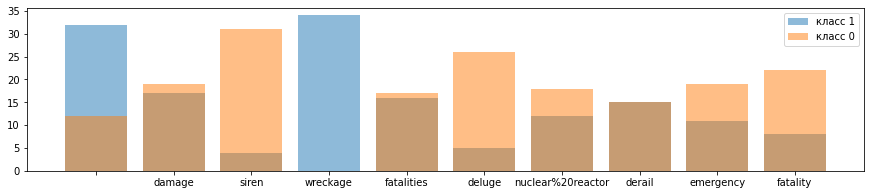

In [15]:
plt.figure(figsize=(15, 3))
plt.bar(x=result['keyword'], height=result['target'], alpha=0.5, label = 'класс 1')
plt.bar(x = result['keyword'], height=result['target0'], alpha=0.5, label = 'класс 0')
plt.legend()

График показывает распределение классов 1 и 0 внутри каждого из 10 самых популярных ключевых слов. Очевидно, что класс 1 преобладает у слов: wreckage и у Nan, однако Nan в дальнейшем никакой информации нести не будет, его можно удалить при желании. В остальных случаях преобладает класс 0, но у таких слов, как derail, fatalities и damage классы распределены почти поровну.  

## Задание 3 (0.5 балла) 

В этом задании предлагается объединить все три текстовых столбца в один (просто сконкатенировать cтроки) и убрать столбец с индексом.

In [16]:
train['new'] = train['keyword'] + ' ' + train['location'] + ' ' + train['text']

<ipython-input-16-79350a5c1232>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['new'] = train['keyword'] + ' ' + train['location'] + ' ' + train['text']


In [17]:
test['new'] = test['keyword'] + ' ' + test['location'] + ' ' + test['text']

<ipython-input-17-db494f3c9e90>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['new'] = test['keyword'] + ' ' + test['location'] + ' ' + test['text']


In [18]:
train.drop(columns = ['id', 'keyword', 'location', 'text'], inplace = True)
test.drop(columns = ['id', 'keyword', 'location', 'text'], inplace = True)

/Users/polinakrupica/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


## Задание 4 (0.5 балла)

Далее мы будем пока работать только с train частью.

1. Предобработайте данные (train часть) с помощью CountVectorizer.
2. Какого размера получилась матрица?


In [19]:
from sklearn.feature_extraction.text import CountVectorizer


In [20]:
cnt_vec = CountVectorizer()
X = cnt_vec.fit_transform(train['new'])

In [21]:
X

<5329x18455 sparse matrix of type '<class 'numpy.int64'>'
	with 86671 stored elements in Compressed Sparse Row format>

Матрица получилась огромная - 5329x18455

## Задание 5 (1 балл)

В предыдущем пункте у вас должна была получиться достаточно большая матрица.
Если вы взгляните на текст, то увидете, что там есть множество специальных символов, ссылок и прочего мусора.

Давайте также посмотрим на словарь, который получился в результате построения CountVectorizer, его можно найти в поле vocabulary_ инстанса этого класса. Давайте напишем функцию, которая печает ответы на следующие вопросы:

1. Найдите в этом словаре все слова, которые содержат цифры. Сколько таких слов нашлось?

2. Найдите все слова, которые содержат символы пунктуации. Сколько таких слов нашлось? 

3. Сколько хэштегов (токен начинается на #) и упоминаний (токен начинается на @) осталось в словаре?

In [22]:
list(cnt_vec.vocabulary_.items())[:100]

[('bridge', 2948),
 ('20collapse', 320),
 ('ashes', 1928),
 ('2015', 295),
 ('australia', 2059),
 ('ûªs', 18425),
 ('collapse', 3914),
 ('at', 1977),
 ('trent', 16483),
 ('among', 1628),
 ('worst', 17813),
 ('in', 8314),
 ('history', 7773),
 ('england', 5722),
 ('bundled', 3085),
 ('out', 11995),
 ('for', 6503),
 ('60', 755),
 ('http', 7970),
 ('co', 3861),
 ('t5trhjuau0', 15733),
 ('hail', 7420),
 ('carol', 3363),
 ('stream', 15419),
 ('illinois', 8249),
 ('great', 7206),
 ('michigan', 10594),
 ('technique', 15888),
 ('camp', 3261),
 ('b1g', 2147),
 ('thanks', 16013),
 ('to', 16272),
 ('bmurph1019', 2753),
 ('hail_youtsey', 7421),
 ('termn8r13', 15949),
 ('goblue', 7088),
 ('wrestleon', 17848),
 ('oaskgki6qj', 11648),
 ('police', 12634),
 ('houston', 7933),
 ('cnn', 3854),
 ('tennessee', 15932),
 ('movie', 10940),
 ('theater', 16025),
 ('shooting', 14647),
 ('suspect', 15632),
 ('killed', 9246),
 ('by', 3150),
 ('di8elzswnr', 4890),
 ('rioting', 13800),
 ('still', 15357),
 ('couple', 

In [23]:
import re

In [24]:
import string

In [25]:
string.punctuation 

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [26]:
def cleaner(dict): 
    number_count = 0
    punct_count = 0
    hash_count = 0
    for i in dict: 
        if re.search('\d', i): 
            number_count += 1
        if re.search('[!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~]', i): 
            punct_count += 1
        if  i[0] == '#': 
            hash_count += 1
        if i[0] == '@': 
            hash_count += 1
        #print(i, ind, (ind == 0 and i[0] == '#'))
    return(number_count, punct_count, hash_count)

In [27]:
cleaner(cnt_vec.vocabulary_)

(3812, 315, 0)

Очевидно, что последний счетчик выдаст 0, тк CountVectorizer удалил все # и @ из начала слов. Также CountVectorizer удалил много знаков препинания.

In [28]:
X

<5329x18455 sparse matrix of type '<class 'numpy.int64'>'
	with 86671 stored elements in Compressed Sparse Row format>

## Задание 6 (0.5 балла)

Вспомним, что на семинаре по текстам мы узнали, что в nltk есть специальный токенизатор для текстов - TweetTokenizer. Попробуем применить CountVectorizer с этим токенизатором. Ответьте на все вопросы из предыдущего пункта для TweetTokenizer и сравните результаты.

In [29]:
from nltk.tokenize import TweetTokenizer
# Чтобы узнать, какие параметры есть у этого токенайзера - используйте help(TweetTokenizer)
# Для того, чтобы передать токенайзер в CountVectorizer используйте параметр tokenizer

In [30]:
help(TweetTokenizer)

Help on class TweetTokenizer in module nltk.tokenize.casual:

class TweetTokenizer(builtins.object)
 |  TweetTokenizer(preserve_case=True, reduce_len=False, strip_handles=False)
 |  
 |  Tokenizer for tweets.
 |  
 |      >>> from nltk.tokenize import TweetTokenizer
 |      >>> tknzr = TweetTokenizer()
 |      >>> s0 = "This is a cooool #dummysmiley: :-) :-P <3 and some arrows < > -> <--"
 |      >>> tknzr.tokenize(s0)
 |      ['This', 'is', 'a', 'cooool', '#dummysmiley', ':', ':-)', ':-P', '<3', 'and', 'some', 'arrows', '<', '>', '->', '<--']
 |  
 |  Examples using `strip_handles` and `reduce_len parameters`:
 |  
 |      >>> tknzr = TweetTokenizer(strip_handles=True, reduce_len=True)
 |      >>> s1 = '@remy: This is waaaaayyyy too much for you!!!!!!'
 |      >>> tknzr.tokenize(s1)
 |      [':', 'This', 'is', 'waaayyy', 'too', 'much', 'for', 'you', '!', '!', '!']
 |  
 |  Methods defined here:
 |  
 |  __init__(self, preserve_case=True, reduce_len=False, strip_handles=False)
 |      

In [31]:
tw_vec = CountVectorizer(tokenizer = TweetTokenizer().tokenize)
T = tw_vec.fit_transform(train['new'])

In [32]:
T

<5329x19670 sparse matrix of type '<class 'numpy.int64'>'
	with 94563 stored elements in Compressed Sparse Row format>

In [33]:
cleaner(tw_vec.vocabulary_)

(3939, 7337, 3149)

Таким образом,TweetTokenizer оставил гораздо больше знаков пунктуации, тк он не удалял смайлики и оставил упоминания и хэштеги в начале токенов. 

## Задание 7 (2 балла)

В scikit-learn мы можем оценивать процесс подсчета матрицы через CountVectorizer. У CountVectorizer, как и у других наследников \_VectorizerMixin, есть аргумент tokenizer и preprocessor. preprocessor применится в самом начале к каждой строке вашего датасета, tokenizer же должен принять строку и вернуть токены.
Давайте напишем кастомный токенайзер, которые сделает все, что нам нужно: 

0. Приведет все буквы к нижнему регистру
1. Разобьет текст на токены с помощью TweetTokenizer из пакета nltk
2. Удалит все токены содержащие не латинские буквы, кроме смайликов (будем считать ими токены содержащие только пунктуацию и, как минимум, одну скобочку) и хэштегов, которые после начальной # содержат только латинские буквы.
3. Удалит все токены, которые перечислены в nltk.corpus.stopwords.words('english')
4. Проведет стемминг с помощью SnowballStemmer

Продемонстрируйте работу вашей функции на первых десяти текстах в обучающей выборке.

In [34]:
import nltk
nltk.download("stopwords")
from nltk.stem.snowball import SnowballStemmer

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/polinakrupica/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [35]:
def custom_token(line): 
    tw = TweetTokenizer()
    from string import punctuation
    a = line
    a = a.lower()
    a = tw.tokenize(a)
    noise = list(punctuation) + nltk.corpus.stopwords.words('english')
    for i in a: 
        if re.search("[^a-zA-Z]+",i) and  not re.search("#[A-Za-z]+", i) and not re.search('[!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~]+[)(]', i ):
            noise.append(i)
    a = list(set(a) - set(noise))    
    stemmer = SnowballStemmer('english')
    stemmed_a = [stemmer.stem(w) for w in a]
    return(stemmed_a)    

In [36]:
# Это пример просто взятый из головы, чтобы показать, что смайлики он сохраняет, потому что в первых 10 строчках трейна нет смайликов

tw = TweetTokenizer()
from string import punctuation
a = 'Dust @Storm e7n routeтт from Alice #Springs to Uluru http://t.co/4ilt6FXU45 #привки :)) .) :-) ;( wanted ûªs'
a = a.lower()
a = tw.tokenize(a)
noise = list(punctuation) + nltk.corpus.stopwords.words('english')
for i in a: 
    if re.search("[^a-zA-Z]+",i) and  not re.search("#[A-Za-z]+", i) and not re.search('[!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~]+[)(]', i ):
        noise.append(i)
a = list(set(a) - set(noise))    
stemmer = SnowballStemmer('english')
stemmed_a = [stemmer.stem(w) for w in a]
print(stemmed_a)

['uluru', 'want', 'dust', '#spring', ':-)', ':)', ';(', 'alic']


In [37]:
for i in train[:10]['new']: 
    print(custom_token(i))

['ash', 'trent', 'collaps', 'england', 'worst', 'among', 'histori', 'bridg', 'australia', 'bundl']
['#goblu', '#wrestleon', 'michigan', 'thank', 'carol', 'hail', 'stream', 'techniqu', 'camp', 'illinoi', 'great']
['houston', 'movi', 'kill', 'tennesse', 'suspect', 'shoot', 'polic', 'cnn', 'theater']
['riot', 'left', 'still', 'class', 'coupl', 'hour']
['left', 'crack', 'run', 'morn', 'highland', 'right', 'path', 'beach', 'lake', 'elbow', 'surfac', 'knee', 'wound', 'wipe']
['#mlb', 'begin', 'reunion', 'expert', 'examin', 'french', 'air', 'island', 'accid', 'debri', 'franc', 'found', 'airplan', 'somewher']
['citi', 'pakistani', 'video', 'perth', 'smirk', 'fun', 'killer', 'boast', 'came', 'world', 'indian', 'bloodi', 'isol', 'show', 'kill', 'remorseless']
['except', 'realli', 'burn', 'idk']
['destroy', 'ask', 'hous']
['exchang', 'nirgua', 'venezuela', 'dead', 'suspect', 'polic', 'offic', 'wound', 'maracay', 'shot']


In [38]:
for i in train[:10]['new']: 
    print(i)

bridge%20collapse  Ashes 2015: AustraliaÛªs collapse at Trent Bridge among worst in history: England bundled out Australia for 60 ... http://t.co/t5TrhjUAU0
hail Carol Stream, Illinois GREAT MICHIGAN TECHNIQUE CAMP
B1G THANKS TO @bmurph1019 
@hail_Youtsey . @termn8r13 
#GoBlue #WrestleOn http://t.co/OasKgki6Qj
police Houston  CNN: Tennessee movie theater shooting suspect killed by police http://t.co/dI8ElZsWNR
rioting  Still rioting in a couple of hours left until I have to be up for class.
wounds Lake Highlands Crack in the path where I wiped out this morning during beach run. Surface wounds on left elbow and right knee. http://t.co/yaqRSximph
airplane%20accident Somewhere Out There Experts in France begin examining airplane debris found on Reunion Island: French air accident experts on... http://t.co/TagZbcXFj0 #MLB
bloody Isolated City In World Perth 'I came to kill Indians...for FUN': Video of smirking and remorseless Pakistani killer shows him boasting. http://t.co/FPjLwOXKlg
bur

## Задание 8 (1 балл)

1. Примените CountVectorizer с реализованным выше токенизатором к обучающим и тестовым выборкам.
2. Обучите LogisticRegression на полученных признаках.
3. Посчитайте метрику f1-score на тестовых данных.

In [39]:
x_train = train['new']
y_train = train['target']

x_test = test['new']
y_test = test['target']

In [41]:
from sklearn.linear_model import LogisticRegression

In [42]:
vec = CountVectorizer(tokenizer = custom_token)
bow = vec.fit_transform(x_train) 
bow_test = vec.transform(x_test)



In [43]:
clf = LogisticRegression(max_iter=200, random_state=42)
clf.fit(bow, y_train)
pred = clf.predict(bow_test)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.80      0.86      0.83      1318
           1       0.79      0.71      0.75       966

    accuracy                           0.80      2284
   macro avg       0.79      0.79      0.79      2284
weighted avg       0.80      0.80      0.79      2284



## Задание 9 (1 балл)

1. Повторите 7 задание, но с tf-idf векторизатором. Как изменилось качество?
2. Мы можем еще сильнее уменьшить размер нашей матрицы, если отбросим значения df близкие к единице. Скорее всего такие слова не несут много информации о категории, так как встречаются достаточно часто. Ограничьте максимальный df в параметрах TfIdfVectorizer, поставьте верхнюю границу равную 0.9. Как изменился размер матрицы, как изменилось качество?
3. Также мы можем уменьшить размер матрицы, удаляя слова со слишком маленьким df. Удалось ли добиться улучшения качества? 

In [44]:
from sklearn.feature_extraction.text import TfidfVectorizer
vec1 = TfidfVectorizer(tokenizer = custom_token)
vec1_train = vec1.fit_transform(x_train)
vec1_test = vec1.transform(x_test)
clf = LogisticRegression(max_iter=300, random_state=42)
clf.fit(vec1_train, y_train)
pred_tfidf = clf.predict(vec1_test)
print(classification_report(y_test, pred_tfidf))

              precision    recall  f1-score   support

           0       0.80      0.90      0.84      1318
           1       0.83      0.69      0.75       966

    accuracy                           0.81      2284
   macro avg       0.81      0.79      0.80      2284
weighted avg       0.81      0.81      0.81      2284



Качество поднялось на одну сотую!

In [45]:
vec2 = TfidfVectorizer(tokenizer = custom_token, max_df = 0.9)
vec2_train = vec2.fit_transform(x_train)
vec2_test = vec2.transform(x_test)


In [46]:
vec2_train

<5329x10571 sparse matrix of type '<class 'numpy.float64'>'
	with 50552 stored elements in Compressed Sparse Row format>

In [47]:

clf = LogisticRegression(max_iter=300, random_state=42)
clf.fit(vec2_train, y_train)
pred_tfidf = clf.predict(vec2_test)
print(classification_report(y_test, pred_tfidf))

              precision    recall  f1-score   support

           0       0.80      0.90      0.84      1318
           1       0.83      0.69      0.75       966

    accuracy                           0.81      2284
   macro avg       0.81      0.79      0.80      2284
weighted avg       0.81      0.81      0.81      2284



Таблица никак не поменялась, потому что 0,9 это слишком высокий порог, нет таких слов, которые бы встречались в каждом предложении. В принципе в нашем датасете повторений слов должно быть видимо не очент много. 

In [48]:
vec3 = TfidfVectorizer(tokenizer = custom_token, max_df = 0.9, min_df = 0.005)
vec3_train = vec3.fit_transform(x_train)
vec3_test = vec3.transform(x_test)



In [49]:
clf = LogisticRegression(max_iter=300, random_state=42)
clf.fit(vec3_train, y_train)
pred_tfidf = clf.predict(vec3_test)
print(classification_report(y_test, pred_tfidf))

              precision    recall  f1-score   support

           0       0.78      0.85      0.81      1318
           1       0.77      0.67      0.71       966

    accuracy                           0.77      2284
   macro avg       0.77      0.76      0.76      2284
weighted avg       0.77      0.77      0.77      2284



In [50]:
vec3 = TfidfVectorizer(tokenizer = custom_token, max_df = 0.9, min_df = 0.0001)
vec3_train = vec3.fit_transform(x_train)
vec3_test = vec3.transform(x_test)
clf = LogisticRegression(max_iter=300, random_state=42)
clf.fit(vec3_train, y_train)
pred_tfidf = clf.predict(vec3_test)
print(classification_report(y_test, pred_tfidf))



              precision    recall  f1-score   support

           0       0.80      0.90      0.84      1318
           1       0.83      0.69      0.75       966

    accuracy                           0.81      2284
   macro avg       0.81      0.79      0.80      2284
weighted avg       0.81      0.81      0.81      2284



Улучшиьть качество не удалось, при очень маленьких min_df ничего не меняется, а при больших - качество падает

## Задание 10 (1 балл)

Еще один популяпный трюк, который позволит уменьшить количество признаков называется hashing trick. Его суть в том, то мы случайно группируем признаки ииии  ..... складываем их! А потом удаляем исходные признаки. В итоге все наши признаки это просто суммы исходных. Звучит странно, но это отлично работает. Давайте проверим этот трюк в нашем сеттинге.
Также при таком подходе вам не нужно хранить словарь token->index, что тоже иногда полезно.

1. Повторите задание 7 с HashingVectorizer, укажите количество фичей равное 5000.
2. Какой из подходов показал самый высокий результат?

In [51]:
from sklearn.feature_extraction.text import HashingVectorizer

In [52]:
hvec = HashingVectorizer(n_features=5000, tokenizer = custom_token) 
hvec_train = hvec.fit_transform(x_train)
hvec_test = hvec.transform(x_test)

/Users/polinakrupica/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:484: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


In [53]:
clf = LogisticRegression(max_iter=300, random_state=42)
clf.fit(hvec_train, y_train)
pred_tfidf = clf.predict(hvec_test)
print(classification_report(y_test, pred_tfidf))

              precision    recall  f1-score   support

           0       0.78      0.88      0.82      1318
           1       0.80      0.66      0.72       966

    accuracy                           0.78      2284
   macro avg       0.79      0.77      0.77      2284
weighted avg       0.79      0.78      0.78      2284



Самый высокий результат показал в итоге подход с TfidfVectorizer, без верхних и нижних границ. 

## Задание 11 (1 балл)

В этом задании нужно добиться f1 меры хотя в 0.75 на тестовых данных.

У меня уже получилось это сделать. Например, используя TfidfVectorizer

In [55]:
from sklearn.feature_extraction.text import TfidfVectorizer
vec1 = TfidfVectorizer(tokenizer = custom_token)
vec1_train = vec1.fit_transform(x_train)
vec1_test = vec1.transform(x_test)
clf = LogisticRegression(max_iter=300, random_state=42)
clf.fit(vec1_train, y_train)
pred_tfidf = clf.predict(vec1_test)
print(classification_report(y_test, pred_tfidf))

              precision    recall  f1-score   support

           0       0.80      0.90      0.84      1318
           1       0.83      0.69      0.75       966

    accuracy                           0.81      2284
   macro avg       0.81      0.79      0.80      2284
weighted avg       0.81      0.81      0.81      2284

